Here I give an exmaple of calculating the multiplet occurence probability histogram for $Sr_2RuO_4$. I assuming that the denisty matrix is calculated (see calc_density_matrix.py)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from h5 import HDFArchive
from triqs.gf import *
from triqs.atom_diag import quantum_number_eigenvalues
from triqs.operators import n
from triqs.operators.util import make_operator_real
from triqs.operators.util.observables import S_op, S2_op
import pandas as pd
pd.set_option('display.width', 130)

In [4]:
with HDFArchive('density_matrix.h5', 'r') as A:
    rho = A['rho']
    h_loc_diag = A['h_loc_diag']

In [5]:
#function written by @the-hampel to calculate observables for each fock state
def get_multiplet_occ(rho, h_loc_diag, orb_names, spin_names = ['up','down'], off_diag = True):
    
    # res will be a list of dictionaries to be a panda data frame
    res = []
    
    # get fundamental operators from atom_diag object
    occ_operators = []
    for op in h_loc_diag.fops:
        occ_operators.append( n(op[0], op[1]) )
    
    # construct total occupation operator from list
    N_op = sum(occ_operators)
    
    # create S2 and Sz operator
    S2 = S2_op(spin_names, orb_names, off_diag=off_diag)
    S2 = make_operator_real(S2)
    
    Sz=S_op('z', spin_names, orb_names, off_diag=off_diag)
    Sz = make_operator_real(Sz)
    
    # get eigenvalues
    S2_states = quantum_number_eigenvalues(S2, h_loc_diag)
    Sz_states = quantum_number_eigenvalues(Sz, h_loc_diag)
        
    # get particle numbers from h_loc_diag
    particle_numbers = quantum_number_eigenvalues(N_op, h_loc_diag)
    
    N_max = int(max(map(max, particle_numbers)))
    multiplet_occ = np.zeros(N_max + 1)

    for sub in range(0,h_loc_diag.n_subspaces):   
        
        # first get fock space spanning the subspace
        fs_states = []
        for ind, fs in enumerate(h_loc_diag.fock_states[sub]):
            # get state in binary representation
            state =int(bin(int(fs))[2:])
            fmt='{0:0'+str(N_max)+'d}'
            fs_states.append("|"+fmt.format(state)+">")
            
        # now extract particle number etc.
        for ind in range(h_loc_diag.get_subspace_dim(sub)):
            
            # get particle number
            # carefully here to not cast to int as the particle number
            # can be something like 1.999999996 and would get then 1! 
            particle_number = round(particle_numbers[sub][ind])
            if abs(particle_number-particle_numbers[sub][ind]) > 1e-8:
                raise ValueError('round error for particle number to large!',particle_numbers[sub][ind])
            else:
                particle_number = int(particle_number)
            # energy of state
            eng=h_loc_diag.energies[sub][ind]
            
            # construct eigenvector in fock state basis:
            ev_state = ''
            for i, elem in enumerate(h_loc_diag.unitary_matrices[sub][:,ind]):
                ev_state += ' {:+1.4f}'.format(elem)+fs_states[i]
            
            # get spin state
            ms = Sz_states[sub][ind]
            s_square = S2_states[sub][ind]
                                    
            # add to data frame
            res.append({"subspace" : sub, 
                        "EV_n0" : ind, 
                        "N" : particle_number, 
                        "energy" : eng,
                        "prob": rho[sub][ind,ind], 
                        "S2": abs(round(s_square,2)),
                        "ms": round(ms,1),
                        "state": ev_state})
    res = pd.DataFrame(res)
        
    return res

In [6]:
res = get_multiplet_occ(rho, h_loc_diag, orb_names= range(3), spin_names=['up','down'], off_diag=False)
print(res)

    subspace  EV_n0  N        energy          prob    S2   ms                             state
0          0      0  4  0.000000e+00  5.162190e-02  2.00  1.0                   +1.0000|100111>
1          1      0  4  3.552714e-15  5.164098e-02  2.00  0.0   +0.7071|101110> +0.7071|110011>
2          1      1  4  8.000000e-01  7.856820e-03  0.00 -0.0   -0.7071|101110> +0.7071|110011>
3          2      0  4  3.552714e-15  5.164734e-02  2.00 -1.0                   +1.0000|111010>
4          3      0  4  8.511301e-02  6.259385e-02  2.00  1.0                   +1.0000|001111>
..       ...    ... ..           ...           ...   ...  ...                               ...
59        39      0  1  8.708455e+00  1.343115e-05  0.75  0.5                   +1.0000|000001>
60        40      0  1  8.708455e+00  1.351825e-05  0.75  0.5                   +1.0000|000100>
61        41      0  1  8.708455e+00  1.331782e-05  0.75 -0.5                   +1.0000|001000>
62        42      0  1  8.708455e+00  1.

Now that we have all of this information, we can use a Pandas pivot_table to get a spin-resolved histogram of particle numbers

In [7]:
tot = res.groupby(['N', 'S2']).sum()
pivot_df = tot.pivot_table(index='N', columns='S2', values='prob')
pivot_df.round(2)

S2,0.00,0.75,2.00,3.75
N,,,,
0,0.00,NaN,NaN,NaN
1,NaN,0.00,NaN,NaN
2,0.00,NaN,0.01,NaN
3,NaN,0.06,NaN,0.15
4,0.05,NaN,0.53,NaN
5,NaN,0.20,NaN,NaN
6,0.01,NaN,NaN,NaN


Now we plot the histogram as a colored bar chart:

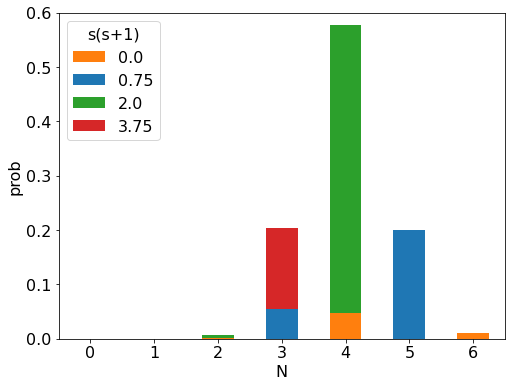

In [8]:
plt.figure(figsize = (8,6))
plt.rc('font', size = 16)
ax = plt.subplot(111)
colors = ['C1', 'C0', 'C2', 'C3', 'C4', 'C5']
pivot_df.plot.bar(stacked = True, rot=0, ax = ax, color = colors)
plt.ylabel('prob')
plt.legend(loc = 'upper left', title = 's(s+1)')
plt.ylim(0,0.6)
plt.show()

We see that, as a Hund's metal, $Sr_2RuO_4$ is dominated by high spin configurations